## Data Loader

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
% cd '/content/drive/MyDrive/ece c247/project'
% ls

/content/drive/MyDrive/ece c247/project
bestM.pt                gen                     X_train_valid.npy
disc                    logs/                   y_test.npy
EEG_loading.ipynb       person_test.npy         y_train_valid.npy
fake_X_train_valid.npy  person_train_valid.npy
fake_y_train_valid.npy  X_test.npy


In [29]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
%load_ext tensorboard
import datetime, os


2.4.1
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [30]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

# adjust labels 
y_train_valid -= 769
y_test -= 769

In [31]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


## Data Preprocessing

In [32]:
def plot_channel(data):
  plt.figure(figsize=(20,10))

  avg = np.mean(data, axis=0)
  name = []
  i = 0
  for channel in avg:
      plt.plot(channel)
      i += 1
      name.append('channel: ' + str(i))
     
  plt.legend(name)
  plt.show()

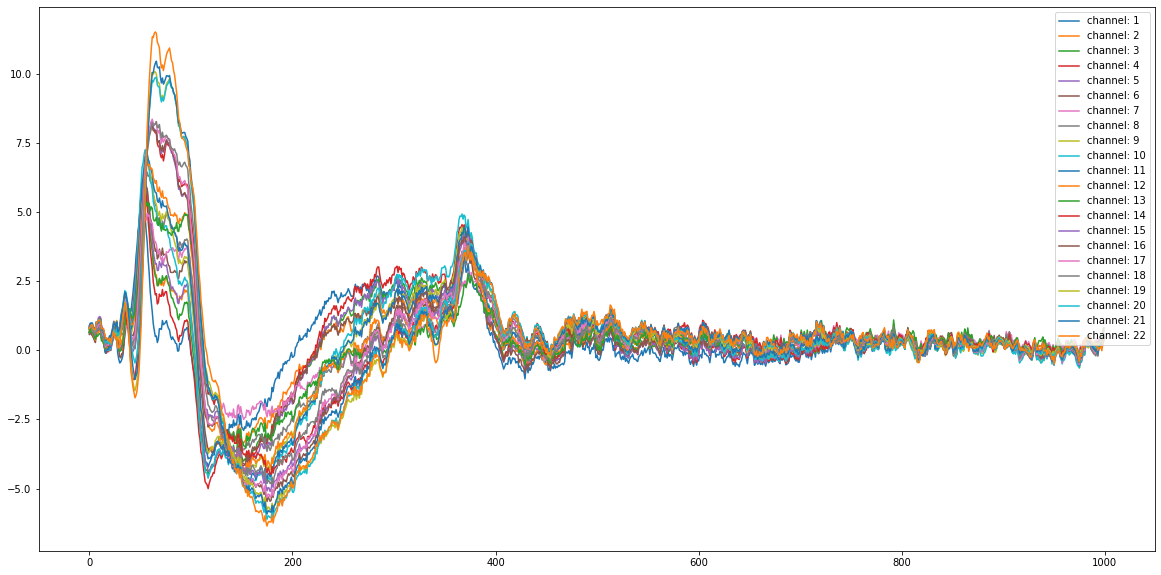

In [33]:
plot_channel(X_train_valid)

In [34]:
# TA's method

def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data
    X = X[:,:,0:500]
    
    # Maxpooling the data
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
        
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid,y_train_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True)

print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

(8460, 22, 250)
(8460,)
(1772, 22, 250)
(1772,)


In [35]:
from keras.utils import to_categorical
y_train_valid_prep = keras.utils.to_categorical(y_train_valid_prep)
y_test_prep = keras.utils.to_categorical(y_test_prep)

print("Shapes of data set after augmentation")
print(X_train_valid_prep.shape)
print(y_train_valid_prep.shape)
print(X_test_prep.shape)
print(y_test_prep.shape)

Shapes of data set after augmentation
(8460, 22, 250)
(8460, 4)
(1772, 22, 250)
(1772, 4)


## Train

In [36]:
from keras.initializers import lecun_uniform
def train(model_type = None, sub_idx=None, time_period=1000, data=None, num_epoch=20, num_batch=100, plot=True):
    # different period of time
    X_train_ = data['X_train'][:, :, :time_period]
    X_test_ = data['X_test'][:, :, :time_period]
    y_train_ = data['y_train']
    y_test_ = data['y_test']

    # single subject dataset
    if sub_idx is not None:
        X_train_ = X_train_[np.where(person_train_valid == sub_idx)[0]]
        y_train_ = y_train_[np.where(person_train_valid == sub_idx)[0]]
        X_test_ = X_test_[np.where(person_test == sub_idx)[0]]
        y_test_ = y_test_[np.where(person_test == sub_idx)[0]]

    # split into train and validation set
    perm = np.random.permutation(X_train_.shape[0])
    numTrain = int(0.8*X_train_.shape[0])
    Xtrain = X_train_[perm[0:numTrain]]
    ytrain = y_train_[perm[0:numTrain]]
    Xval = X_train_[perm[numTrain: ]]
    yval = y_train_[perm[numTrain: ]]

    lecun = lecun_uniform()
    model = model_type(lecun, time_period)

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    history = model.fit(Xtrain, ytrain, epochs=num_epoch, batch_size=num_batch, validation_data=(Xval, yval), shuffle=True, verbose=1, callbacks=[tensorboard_callback])
    train_score = model.evaluate(X_train_, y_train_)
    test_score = model.evaluate(X_test_, y_test_)

    if plot:
      print(model.summary())

      # Plot training & validation accuracy values
      plt.plot(history.history['categorical_accuracy'])
      plt.plot(history.history['val_categorical_accuracy'])
      plt.title('Model accuracy')
      plt.ylabel('Accuracy')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

      # Plot training & validation loss values
      plt.plot(history.history['loss'])
      plt.plot(history.history['val_loss'])
      plt.title('Model loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Validation'], loc='upper left')
      plt.show()

    return train_score[1]*100, test_score[1]*100

## Models

In [37]:
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, Permute, Reshape
from keras.regularizers import L1L2

### CNN-Res to be added

### Taixing

In [38]:
from keras.layers import BatchNormalization, Conv2D, Dense, Dropout, ELU, Flatten, MaxPool2D, Permute, Reshape, AveragePooling1D
from keras.regularizers import L2

def cnn5(kernel_initializer, time_period):
    model = Sequential()
    
    model.add(Reshape((22, time_period, 1), input_shape=(22, time_period)))
    model.add(Conv2D(29, kernel_size=(1, 4)))
    model.add(Conv2D(29, kernel_size=(22, 1)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Conv2D(49, kernel_size=(1, 6)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))

    model.add(Conv2D(104, kernel_size=(1, 5)))
    model.add(BatchNormalization(axis=-1))
    model.add(ELU())
    model.add(MaxPool2D(1,2))
    model.add(Dropout(0.5))


    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

In [ ]:
data = {
    'X_train': X_train_valid_prep,
    'X_test': X_test_prep,
    'y_train': y_train_valid_prep,
    'y_test': y_test_prep
}

train_acc, test_acc = train(cnn5, data=data, time_period=250, num_epoch=50, num_batch=64)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)
%tensorboard --logdir logs

Epoch 1/50
106/106 [==============================] - 3s 20ms/step - loss: 1.8867 - categorical_accuracy: 0.3106 - val_loss: 1.2464 - val_categorical_accuracy: 0.4574
Epoch 2/50
106/106 [==============================] - 2s 15ms/step - loss: 1.4800 - categorical_accuracy: 0.4138 - val_loss: 0.9842 - val_categorical_accuracy: 0.5857
Epoch 3/50
106/106 [==============================] - 2s 14ms/step - loss: 1.2325 - categorical_accuracy: 0.4959 - val_loss: 0.9256 - val_categorical_accuracy: 0.6093
Epoch 4/50
106/106 [==============================] - 1s 14ms/step - loss: 1.0999 - categorical_accuracy: 0.5528 - val_loss: 0.8020 - val_categorical_accuracy: 0.6838
Epoch 5/50
106/106 [==============================] - 2s 14ms/step - loss: 1.0309 - categorical_accuracy: 0.5787 - val_loss: 0.7901 - val_categorical_accuracy: 0.6791
Epoch 6/50
106/106 [==============================] - 2s 14ms/step - loss: 0.9737 - categorical_accuracy: 0.6124 - val_loss: 0.7380 - val_categorical_accuracy: 0.704

### CNN+GRU

In [ ]:
from keras.layers import Conv1D, MaxPool1D, GRU
from keras.optimizers import Adam
def CNN_GRU(kernel_initializer, time_period, hidden_dim = 50):
    model = Sequential()

    model.add(Conv1D(20, kernel_size=10, input_shape=(22, time_period), kernel_regularizer=L1L2(0, 0.35)))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool1D(2))

    model.add(GRU(50, kernel_regularizer=L1L2(0, 0.35), return_sequences=True))

    model.add(Flatten())
    model.add(Dense(20))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[categorical_accuracy])

    return model

In [ ]:
data = {
    'X_train': X_train_aug,
    'X_test': X_test,
    'y_train': y_train_aug,
    'y_test': y_test
}

train_acc, test_acc = train(CNN_GRU, data=data, time_period=500, num_epoch=50)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### CNN+LSTM

In [ ]:
from keras.layers import LSTM
from keras.optimizers import Adam
def CNN_LSTM(kernel_initializer, time_period, hidden_dim = 50):
    model = Sequential()

    model.add(Conv1D(20, kernel_size=10, input_shape=(22, time_period), kernel_regularizer=L1L2(0, 0.2)))
    model.add(BatchNormalization(axis=1))
    model.add(MaxPool1D(2))

    model.add(LSTM(hidden_dim, kernel_regularizer=L1L2(0, 0.2), return_sequences=True))

    model.add(Flatten())
    model.add(Dense(32))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation='softmax'))

    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[categorical_accuracy])

    return model

## Experiments

### Optimize for subject 1

Epoch 1/30
2/2 [==============================] - 7s 2s/step - loss: 5.2845 - categorical_accuracy: 0.2244 - val_loss: 5.1063 - val_categorical_accuracy: 0.1875
Epoch 2/30
2/2 [==============================] - 0s 203ms/step - loss: 4.7997 - categorical_accuracy: 0.5055 - val_loss: 4.9355 - val_categorical_accuracy: 0.2292
Epoch 3/30
2/2 [==============================] - 0s 202ms/step - loss: 4.4542 - categorical_accuracy: 0.5776 - val_loss: 4.7493 - val_categorical_accuracy: 0.2708
Epoch 4/30
2/2 [==============================] - 0s 201ms/step - loss: 4.1432 - categorical_accuracy: 0.6027 - val_loss: 4.4771 - val_categorical_accuracy: 0.3125
Epoch 5/30
2/2 [==============================] - 0s 213ms/step - loss: 3.8636 - categorical_accuracy: 0.6791 - val_loss: 4.2041 - val_categorical_accuracy: 0.3542
Epoch 6/30
2/2 [==============================] - 0s 203ms/step - loss: 3.5285 - categorical_accuracy: 0.7748 - val_loss: 3.9843 - val_categorical_accuracy: 0.3958
Epoch 7/30
2/2 [===

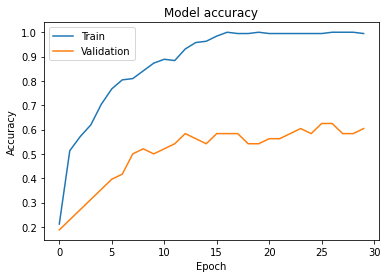

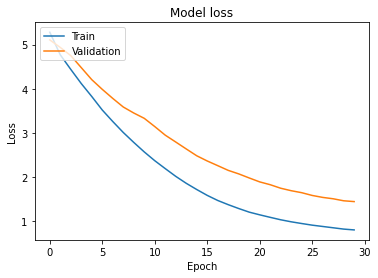

Training Accuracy: 91.56118035316467
Test Accuracy: 43.99999976158142


In [ ]:
data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

train_acc, test_acc = train(cnn2, sub_idx=0, data=data, num_epoch=30)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### Optimize across all subjects

In [ ]:
data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

train_acc, test_acc = train(cnn2, data=data, time_period=400, num_epoch=50)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

### Optimize as a function of time

Time Period = 200
Epoch 1/40
17/17 [==============================] - 16s 177ms/step - loss: 2.4870 - categorical_accuracy: 0.2830 - val_loss: 2.2685 - val_categorical_accuracy: 0.3712
Epoch 2/40
17/17 [==============================] - 1s 42ms/step - loss: 2.2391 - categorical_accuracy: 0.3792 - val_loss: 2.0871 - val_categorical_accuracy: 0.4374
Epoch 3/40
17/17 [==============================] - 1s 42ms/step - loss: 2.0663 - categorical_accuracy: 0.4491 - val_loss: 1.9502 - val_categorical_accuracy: 0.4232
Epoch 4/40
17/17 [==============================] - 1s 42ms/step - loss: 1.9047 - categorical_accuracy: 0.4740 - val_loss: 1.8303 - val_categorical_accuracy: 0.4799
Epoch 5/40
17/17 [==============================] - 1s 42ms/step - loss: 1.7822 - categorical_accuracy: 0.5010 - val_loss: 1.7363 - val_categorical_accuracy: 0.4823
Epoch 6/40
17/17 [==============================] - 1s 42ms/step - loss: 1.6858 - categorical_accuracy: 0.4983 - val_loss: 1.6345 - val_categorical_accurac

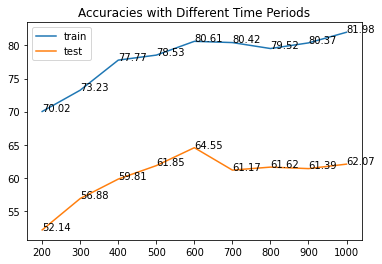

In [ ]:
train_scores = []
test_scores = []
times = [200, 300, 400, 500, 600, 700, 800, 900, 1000]

data = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}

for t in times:
  print("Time Period = %d" %(t))
  train_acc, test_acc = train(cnn2, time_period=t, data=data, num_epoch=40, plot=False)
  train_scores.append(train_acc)
  test_scores.append(test_acc)

plt.plot(times, train_scores, label='train')
plt.plot(times, test_scores, label='test')
plt.legend()
plt.title("Accuracies with Different Time Periods")
for a, b, c in zip(times, train_scores, test_scores): 
    plt.text(a, b, str(b)[:5])
    plt.text(a, c, str(c)[:5])

Time Period = 200
Epoch 1/50
51/51 [==============================] - 5s 84ms/step - loss: 2.3558 - categorical_accuracy: 0.3496 - val_loss: 1.9725 - val_categorical_accuracy: 0.4326
Epoch 2/50
51/51 [==============================] - 2s 43ms/step - loss: 1.8345 - categorical_accuracy: 0.4779 - val_loss: 1.6061 - val_categorical_accuracy: 0.5043
Epoch 3/50
51/51 [==============================] - 2s 43ms/step - loss: 1.5184 - categorical_accuracy: 0.5355 - val_loss: 1.4104 - val_categorical_accuracy: 0.5083
Epoch 4/50
51/51 [==============================] - 2s 43ms/step - loss: 1.3378 - categorical_accuracy: 0.5469 - val_loss: 1.2994 - val_categorical_accuracy: 0.5185
Epoch 5/50
51/51 [==============================] - 2s 43ms/step - loss: 1.2786 - categorical_accuracy: 0.5271 - val_loss: 1.2479 - val_categorical_accuracy: 0.5382
Epoch 6/50
51/51 [==============================] - 2s 43ms/step - loss: 1.2127 - categorical_accuracy: 0.5497 - val_loss: 1.2142 - val_categorical_accuracy:

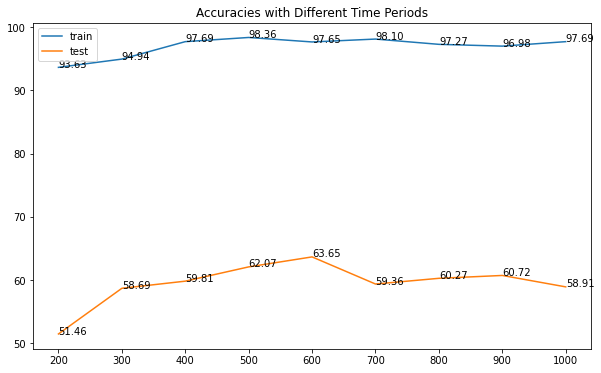

In [ ]:
train_scores = []
test_scores = []
times = [200, 300, 400, 500, 600, 700, 800, 900, 1000]
data = {
    'X_train': X_train_aug,
    'X_test': X_test,
    'y_train': y_train_aug,
    'y_test': y_test
}

for t in times:
  print("Time Period = %d" %(t))
  train_acc, test_acc = train(cnn2, time_period=t, data=data, num_epoch=50, plot=False)
  train_scores.append(train_acc)
  test_scores.append(test_acc)

plt.figure(figsize=(10,6))
plt.plot(times, train_scores, label='train')
plt.plot(times, test_scores, label='test')
plt.legend()
plt.title("Accuracies with Different Time Periods")
for a, b, c in zip(times, train_scores, test_scores): 
    plt.text(a, b, str(b)[:5])
    plt.text(a, c, str(c)[:5])

### Compare Data Processing Technique

In [ ]:
data1 = {
    'X_train': X_train_valid,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}
train_acc, test_acc = train(cnn2, time_period=200, data=data1, num_epoch=20, plot=False)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)

data2 = {
    'X_train': X_train_gaussian,
    'X_test': X_test,
    'y_train': y_train_valid,
    'y_test': y_test
}
train_acc, test_acc = train(cnn2, time_period=200, data=data2, num_epoch=20, plot=False)
print("Training Accuracy:", train_acc)
print("Test Accuracy:", test_acc)